In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

from sklearn.metrics import roc_auc_score

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df_train = pd.read_csv("gdrive/MyDrive/ML/diabetes/train.csv")
df_test = pd.read_csv("gdrive/MyDrive/ML/diabetes/test.csv")

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [6]:
df_train.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [7]:
print(df_train.shape, df_test.shape)

(700000, 26) (300000, 25)


### 1. Feature engineering

To reduce noise in continuous variables and help models learn more stable patterns, we apply **threshold binning** to selected numerical features. Binning converts continuous values into discrete risk intervals, which can improve robustness and make non-linear effects easier to capture.

We implement two binning strategies:

1. **Naive quantile binning**
   - Each continuous feature is discretized into **20 quantile bins** (chosen by trial and error on feature importance of bins)
   - Provides uniform bin counts and acts as a simple baseline discretization method

2. **AI-based binning (decision tree thresholds)**
   - For each feature, we fit a **single-feature decision tree** to predict the target `y`.
   - Tree split thresholds are extracted and used as bin edges.
   - We restrict the decision tree to **max_depth = 3**, yielding up to **8 bins**.
     - This limits complexity, reduces overfitting risk, and keeps bins interpretable while still capturing non-linear cut-offs.

In [8]:
target_cols_to_bin = [
    "age",
    "alcohol_consumption_per_week",
    "physical_activity_minutes_per_week",
    "diet_score",
    "sleep_hours_per_day",
    "screen_time_hours_per_day",
    "bmi",
    "waist_to_hip_ratio",
    "systolic_bp",
    "diastolic_bp",
    "heart_rate",
    "cholesterol_total",
    "hdl_cholesterol",
    "ldl_cholesterol",
    "triglycerides"
]

In [9]:
# 1. Helper functions
def fit_simple_binning(series, q=20):
    # Simple quantile based binning, 20 bins

    # 1. qcut into q bins, just want the bin thresholds, duplicates = 'drop' handles cases where many users have the exact same value
    _, bins = pd.qcut(series, q=q, retbins=True, duplicates='drop')

    # 2. Add safety edges in case of different min/max in X_test
    bins[0] = -np.inf
    bins[-1] = np.inf
    return bins

def fit_ai_binning(X, y, col, max_depth=3):
    # Use decision tree splits as thresholds for bins, max_depth = 3 for now

    # 1. We fill the column of interesrt with mean if there are NAs, for stability of tree
    X_clean = X[[col]].fillna(X[col].mean())

    # 2. DT training and fitting
    dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=0.05, random_state=5)
    dt.fit(X_clean, y)

    # 3. Extract non-leaf thresholds (-2) from the tree structure
    thresholds = [t for t in dt.tree_.threshold if t != -2]

    # 4. Sort and add safety edges
    return [-np.inf] + sorted(thresholds) + [np.inf]

def apply_binning(series, bins):
    return pd.cut(series, bins=bins, labels=False, include_lowest=True).astype(str)

In [11]:
# 1. Prepare data

# Split data into X, y, X_test
drop_cols = ['id', 'diagnosed_diabetes']

X = df_train.drop(columns=drop_cols, errors='ignore')
y = df_train['diagnosed_diabetes']

X_test = df_test.drop(columns=drop_cols, errors='ignore')

# List of features
ordinal_cat_features = ["income_level", "education_level"]
ord_feature_categories = [
    ["Low", "Lower-Middle", "Middle", "Upper-Middle", "High"],
    ["No formal", "Highschool", "Graduate", "Postgraduate"]
]

# Identify categorical features (but keep as object/bool in dataframe)
cat_like = set(X.select_dtypes(include=["bool", "object", "category"]).columns)
cat_like |= {"cardiovascular_history", "hypertension_history", "family_history_diabetes"}
onehot_cat_features = list(cat_like - set(ordinal_cat_features))
num_features = [f for f in X.columns if f not in (ordinal_cat_features + onehot_cat_features)]

# IMPORTANT: Convert categorical columns back to object dtype for sklearn
# sklearn pipelines work better with object dtype than pandas category dtype
for col in (ordinal_cat_features + onehot_cat_features):
    if col in X.columns:
        # Convert bool to string, keep category/object as object
        if X[col].dtype == 'bool':
            X[col] = X[col].astype(str)
            X_test[col] = X_test[col].astype(str)
        elif X[col].dtype.name == 'category':
            X[col] = X[col].astype(object)
            X_test[col] = X_test[col].astype(object)

# Simple quantile binning
simple_bin_storage = {}
for col in target_cols_to_bin:
    bins = fit_simple_binning(X[col])
    simple_bin_storage[col] = bins
    feature_name = f'{col}_simple_bin'

    X[feature_name] = apply_binning(X[col], bins)
    X_test[feature_name] = apply_binning(X_test[col], bins)
    ordinal_cat_features.append(feature_name)

In [13]:
# 2. Model training
# a. Logistic Regression
params_lr = {
    "max_iter": 2000,
    "random_state": 5,
    "class_weight": "balanced",
    "solver": "liblinear",
    "penalty": "l2",
    "n_jobs": -1
}

In [14]:
# b. Random Forest
params_rf = {
    "n_estimators": 500,
    "random_state": 5,
    "class_weight": "balanced_subsample",
    "min_samples_leaf": 20,
    "max_features": "sqrt",
    "n_jobs": -1
}

In [15]:
# c. Catboost
params_catboost = {
      "iterations": 2000,
      "loss_function": "Logloss",
      "eval_metric": "Logloss",
      "random_seed": 5,
      "verbose": False,
      "auto_class_weights": "Balanced",
      "task_type": 'GPU',
      "devices": '0'
}

In [16]:
# d. LightGBM
params_lgb = {
    "num_iterations": 2000,
    "device_type": "gpu",
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'seed': 5,
    'is_unbalance': True
}

### 2. Model training with leakage-safe AI binning

We train the same 4 baseline models (**LR, RF, CatBoost, LightGBM**) with the added binned features, while taking care to prevent **data leakage**.

Given `X, y` (training data) and `X_test` (test data):

#### Step 1: Quantile binning (safe)
- Run `fit_simple_binning(X)` on the training set only.
- Apply the learned bin edges via `apply_binning()` to both `X` and `X_test`.

#### Step 2: AI binning + hyperparameter tuning (must be inside CV)
AI-based binning is supervised (uses `y`) because decision trees learn thresholds from `X` using `y`.  
Therefore, it must be performed **within cross-validation**, otherwise bin edges would indirectly encode validation target information and inflate AUC.

We perform leakage-safe AI binning and tuning using **Stratified K-Fold CV**:

For each fold:
1. Split into `(X_train_fold, y_train_fold)` and `(X_val_fold, y_val_fold)`
2. Run `fit_ai_binning(X_train_fold, y_train_fold)` to learn DT-derived thresholds
3. Apply bins to both `X_train_fold` and `X_val_fold`
4. Predict and evaluate AUC on `y_val_fold`

This combined pipeline ensures that DT-derived bins are learned **only from training folds**, preventing leakage and producing valid out-of-fold AUC estimates.

In [20]:
# 3. CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_scores = {
    "lr": [],
    "rf": [],
    "catboost": [],
    "lgb": []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f'Training fold {fold}...')
    X_train_fold = X.iloc[train_idx].copy()
    y_train_fold = y.iloc[train_idx].copy()
    X_val_fold = X.iloc[val_idx].copy()
    y_val_fold = y.iloc[val_idx].copy()

    fold_ordinal_cat = ordinal_cat_features.copy()
    fold_onehot_cat = onehot_cat_features.copy()

    # --- FIX 1: Construct the 'categories' list explicitly ---
    # We need a list of categories for EVERY ordinal column in the exact order they appear in fold_ordinal_cat
    # 1. Start with the fixed categories (Income, Education)
    current_fold_categories = [c[:] for c in ord_feature_categories]

    # 2. Add categories for the SIMPLE bins (already in X)
    # These correspond to the columns added to 'ordinal_cat_features' outside the loop
    for col in target_cols_to_bin:
        bins = simple_bin_storage[col]
        # Bins result in indices 0 to N-1. apply_binning converts them to strings.
        # So we generate ['0', '1', ..., 'N-1']
        cats = [str(i) for i in range(len(bins) - 1)]
        current_fold_categories.append(cats)

    # 3. Apply AI binning within fold
    for col in target_cols_to_bin:
        # Fit bins on TRAIN
        bins = fit_ai_binning(X_train_fold, y_train_fold, col)

        # Apply to TRAIN and VALIDATION
        feature_name = f'{col}_ai_bin'
        X_train_fold[feature_name] = apply_binning(X_train_fold[col], bins)

        # --- FIX 2: Apply binning to the VALIDATION column, not TRAIN ---
        X_val_fold[feature_name] = apply_binning(X_val_fold[col], bins)

        # Update feature lists
        fold_ordinal_cat.append(feature_name)

        # Add the categories for this new AI-binned feature to our list
        cats = [str(i) for i in range(len(bins) - 1)]
        current_fold_categories.append(cats)

    # Identify numerical features after all binning is done
    fold_num_features = [f for f in X_train_fold.columns if f not in (fold_ordinal_cat + fold_onehot_cat)]

    # 4. Init pipelines for current fold
    ord_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            handle_unknown='use_encoded_value',
            categories=current_fold_categories,  # --- FIX 1: Pass the full, correct list here
            unknown_value=-1
        ))
    ])

    ohe_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    num_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])

    col_trans = ColumnTransformer([
        ('ord_pipeline', ord_pipeline, fold_ordinal_cat),
        ('ohe_pipeline', ohe_pipeline, fold_onehot_cat),
        ("num_pipeline", num_pipeline, fold_num_features)
    ], remainder='drop')

    # a. Logistic regression
    lr = Pipeline([("prep", col_trans), ("clf", LogisticRegression(**params_lr))])
    lr.fit(X_train_fold, y_train_fold)
    preds_lr = lr.predict_proba(X_val_fold)[:, 1]
    cv_scores["lr"].append(roc_auc_score(y_val_fold, preds_lr))
    print(f'Fold {fold} LR complete.')

    # b. Random forest
    rf = Pipeline([("prep", col_trans), ("clf", RandomForestClassifier(**params_rf))])
    rf.fit(X_train_fold, y_train_fold)
    preds_rf = rf.predict_proba(X_val_fold)[:, 1]
    cv_scores["rf"].append(roc_auc_score(y_val_fold, preds_rf))
    print(f'Fold {fold} RF complete.')

    # c. Catboost
    # IMPT Convert object dtypes to category for CatBoost
    fold_cat_features = fold_ordinal_cat + fold_onehot_cat
    X_train_boost = X_train_fold.copy()
    X_val_boost = X_val_fold.copy()

    for col in fold_cat_features:
        if col in X_train_boost.columns:
            X_train_boost[col] = X_train_boost[col].astype('category')
            X_val_boost[col] = X_val_boost[col].astype('category')

    train_pool = Pool(X_train_boost, y_train_fold, cat_features=fold_cat_features)
    val_pool = Pool(X_val_boost, y_val_fold, cat_features=fold_cat_features)

    model_cat = CatBoostClassifier(**params_catboost)
    model_cat.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        early_stopping_rounds=100
    )
    preds_cat = model_cat.predict_proba(val_pool)[:, 1]
    cv_scores["catboost"].append(roc_auc_score(y_val_fold, preds_cat))
    print(f'Fold {fold} catboost complete.')

    # d. LightGBM
    dtrain = lgb.Dataset(
        X_train_boost,
        label=y_train_fold,
        categorical_feature=fold_cat_features,
        free_raw_data=False
    )
    dvalid = lgb.Dataset(
        X_val_boost,
        label=y_val_fold,
        categorical_feature=fold_cat_features,
        reference=dtrain,
        free_raw_data=False
    )

    model_lgb = lgb.train(
        params_lgb,
        dtrain,
        num_boost_round=5000,
        valid_sets=[dvalid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )
    preds_lgb = model_lgb.predict(X_val_boost, num_iteration=model_lgb.best_iteration)
    cv_scores["lgb"].append(roc_auc_score(y_val_fold, preds_lgb))
    print(f'Fold {fold} LGB complete.')

    print(f"Fold {fold} completed.")

Training fold 1...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Fold 1 LR complete.
Fold 1 RF complete.
Fold 1 catboost complete.
Fold 1 LGB complete.
Fold 1 completed.
Training fold 2...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Fold 2 LR complete.
Fold 2 RF complete.
Fold 2 catboost complete.
Fold 2 LGB complete.
Fold 2 completed.
Training fold 3...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Fold 3 LR complete.
Fold 3 RF complete.
Fold 3 catboost complete.
Fold 3 LGB complete.
Fold 3 completed.
Training fold 4...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Fold 4 LR complete.
Fold 4 RF complete.
Fold 4 catboost complete.
Fold 4 LGB complete.
Fold 4 completed.
Training fold 5...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Fold 5 LR complete.
Fold 5 RF complete.
Fold 5 catboost complete.
Fold 5 LGB complete.
Fold 5 completed.


In [21]:
print("\n=== Cross-Validation Results ===")
for k, scores in cv_scores.items():
    print(f"{k}: mean AUC = {float(np.mean(scores)):.6f} | std = {float(np.std(scores)):.6f}")


=== Cross-Validation Results ===
lr: mean AUC = 0.698481 | std = 0.000595
rf: mean AUC = 0.702733 | std = 0.000601
catboost: mean AUC = 0.724559 | std = 0.000364
lgb: mean AUC = 0.722209 | std = 0.000250


### 3. Results interpretation

We compare two feature engineering strategies: **clinical indicator flags** vs **threshold binning**. Overall, both approaches yield **very similar performance**, suggesting that discretization-style feature engineering is beneficial and fairly robust across models.

#### Key observations
- **CatBoost and LightGBM consistently outperform LR and RF**, achieving AUC ≈ **0.72–0.73**, indicating that boosting models are better at capturing non-linear risk patterns and feature interactions in this dataset.
- **LR and RF performance is lower and tightly clustered** (AUC ≈ **0.695–0.703**), showing weaker ability to exploit complex non-linear structure even with engineered features.

#### Indicators vs threshold bins
- **Threshold bins improve LR slightly** relative to indicator features  
  (0.6985 vs 0.6950), suggesting binning helps linear models by introducing structured non-linearity.
- **RF is comparable under both settings**, with a very small gain under threshold bins  
  (0.7027 vs 0.7011), implying tree ensembles already learn thresholds naturally.
- **CatBoost is essentially unchanged**, with a marginal edge for threshold bins  
  (0.7246 vs 0.7238), suggesting that boosting already captures non-linearities well even without heavy discretization.
- **LightGBM performs slightly better with indicator features**  
  (0.7253 vs 0.7222), suggesting domain-driven flags may align well with LGBM’s split structure.

#### Stability
All models show low standard deviations across folds (~0.00025–0.00060), meaning results are highly stable and differences are likely small in practical terms.

**Conclusion:** both feature engineering strategies are valid, but the main performance driver is model choice: **Boosting models dominate**. Threshold bins appear most helpful for **linear models**, while indicators can be equally (or slightly more) useful for **LightGBM**.

Training Final LightGBM Model...
[500]	training's auc: 0.766385
[1000]	training's auc: 0.803864
[1500]	training's auc: 0.836415
[2000]	training's auc: 0.86412


<Figure size 1200x1000 with 0 Axes>

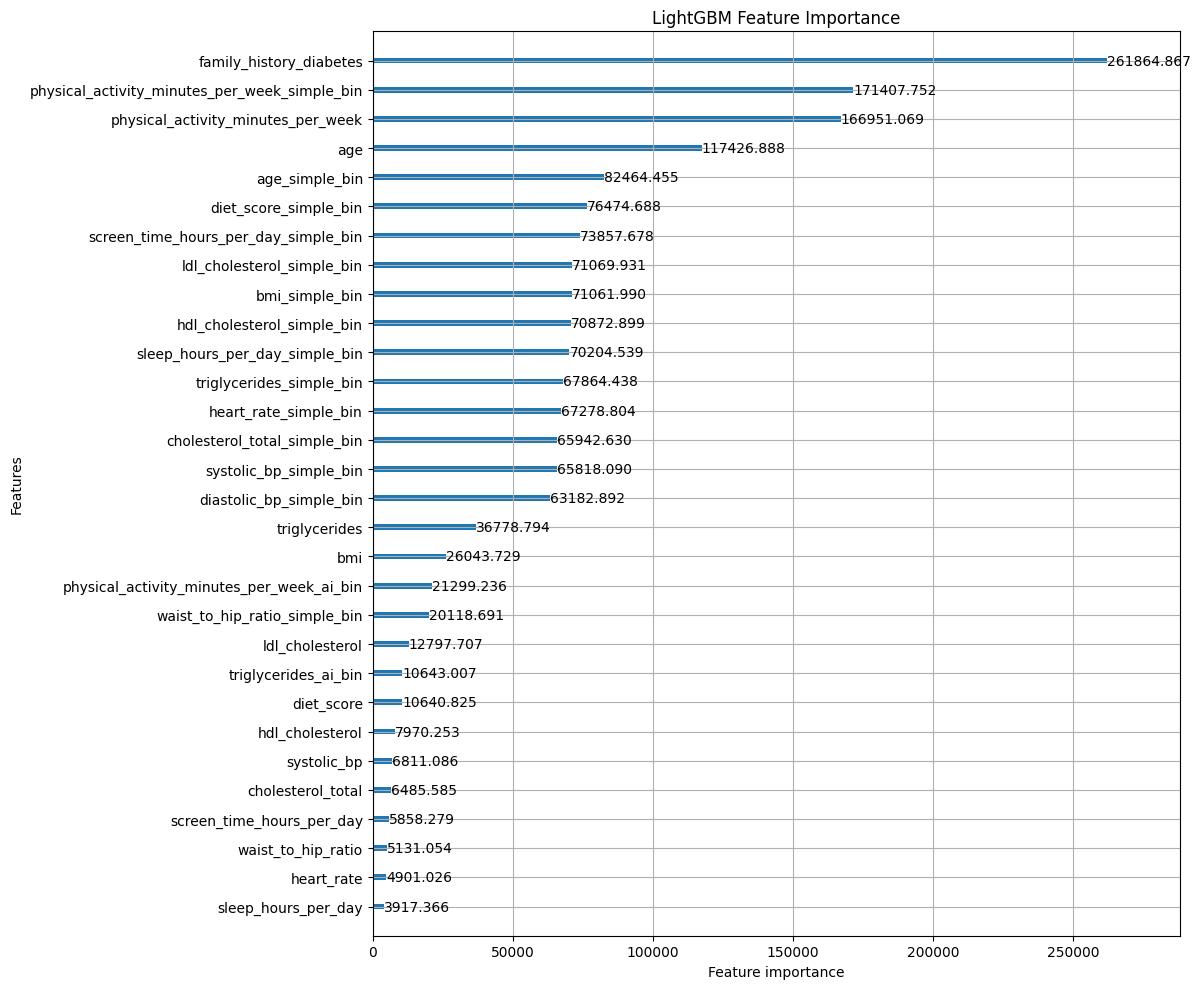

Training Final CatBoost Model...
Learning rate set to 0.012635
0:	learn: 0.6915787	total: 297ms	remaining: 9m 54s
500:	learn: 0.6210265	total: 2m 10s	remaining: 6m 29s
1000:	learn: 0.6161315	total: 4m 16s	remaining: 4m 15s
1500:	learn: 0.6127369	total: 6m 21s	remaining: 2m 6s
1999:	learn: 0.6105917	total: 8m 27s	remaining: 0us


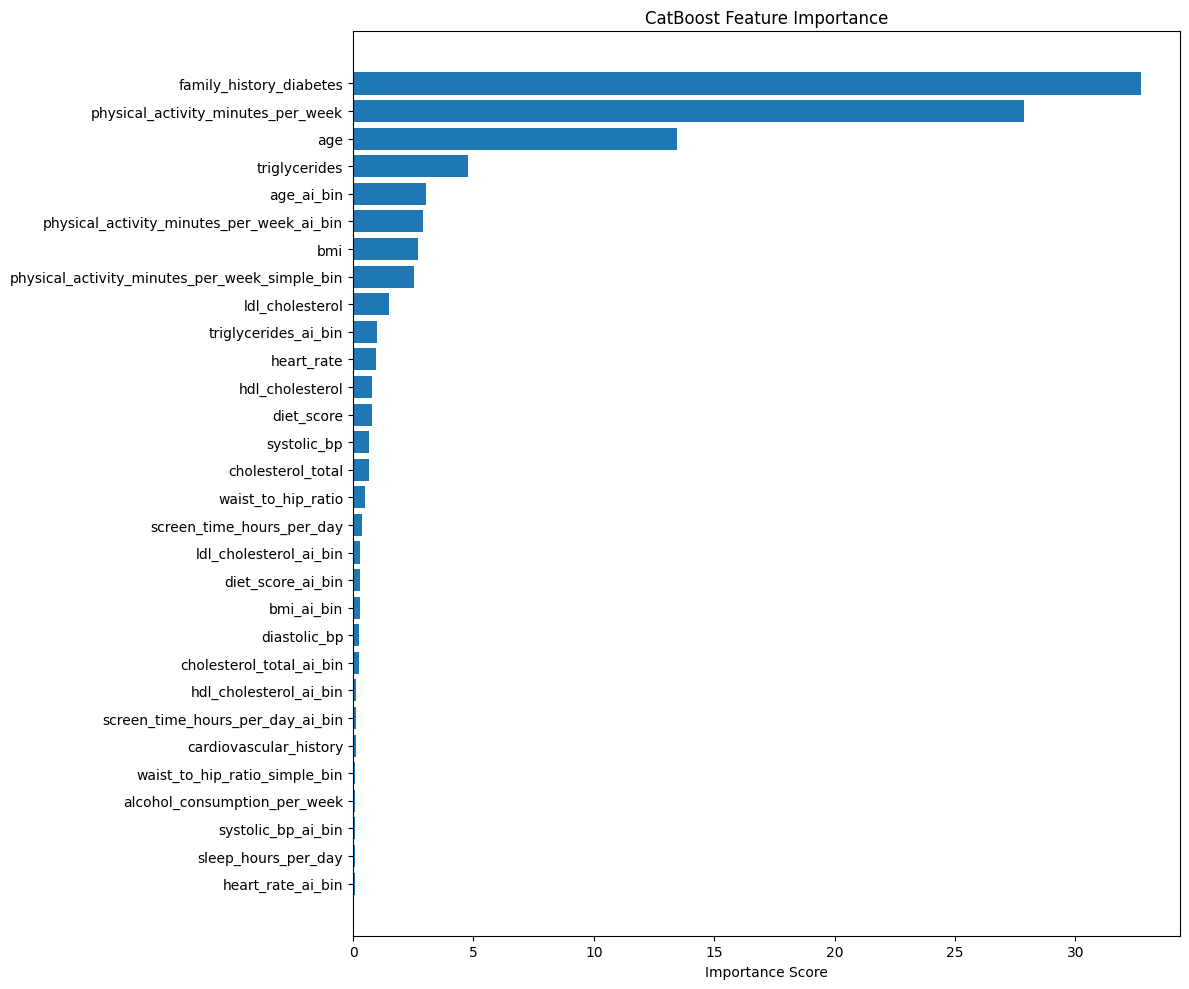

In [22]:
# 4. Feature importance based on full X
base_cat_features = ordinal_cat_features + onehot_cat_features

final_cat_features = base_cat_features.copy()
X_final_train = X.copy()
X_final_test = X_test.copy()

# a. Apply AI binning
for col in target_cols_to_bin:
    bins = fit_ai_binning(X_final_train, y, col)

    feature_name = f'{col}_ai_bin'
    X_final_train[feature_name] = apply_binning(X_final_train[col], bins)
    X_final_test[feature_name] = apply_binning(X_final_test[col], bins)

    final_cat_features.append(feature_name)

# Ensure categorical columns are cast to 'category' dtype
for col in final_cat_features:
    X_final_train[col] = X_final_train[col].astype('category')
    X_final_test[col] = X_final_test[col].astype('category')

# b. LightGBM
print("Training Final LightGBM Model...")

final_params_lgb = params_lgb.copy()
num_boost_round = final_params_lgb.pop('num_iterations', 2000)

dtrain_full = lgb.Dataset(X_final_train, label=y, categorical_feature=final_cat_features)

lgb_final = lgb.train(
    final_params_lgb,
    dtrain_full,
    num_boost_round=num_boost_round,
    valid_sets=[dtrain_full],
    callbacks=[lgb.log_evaluation(period=500)]
)

# Plot LightGBM feature importance
plt.figure(figsize=(12, 10))
lgb.plot_importance(lgb_final, max_num_features=30, importance_type='gain', figsize=(12, 10), title='LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# c. Catboost
print("Training Final CatBoost Model...")

final_params_cat = params_catboost.copy()
final_params_cat['verbose'] = 500

train_pool_full = Pool(X_final_train, y, cat_features=final_cat_features)

cat_final = CatBoostClassifier(**final_params_cat)
cat_final.fit(train_pool_full)

# Plot CatBoost Feature Importance
feature_importance = cat_final.get_feature_importance(train_pool_full)
sorted_idx = np.argsort(feature_importance)[-30:] # Get indices of top 30 features

plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_final_train.columns)[sorted_idx])
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

### 4. Feature importance interpretation

Both CatBoost and LightGBM identify a highly consistent set of dominant predictors:

#### Main drivers (consistent across both models)
- **family_history_diabetes** is the strongest feature by a large margin, suggesting genetic predisposition is the most predictive signal in the dataset.
- **physical_activity_minutes_per_week** and **age** are the next most important features, indicating strong lifestyle + demographic effects on risk.
- Lipid-related indicators (e.g., **triglycerides**, **LDL**) and **BMI** appear as secondary drivers, contributing additional risk information.

### Effect of binning features
- LightGBM assigns very high importance to **quantile-binned (“_simple_bin”) features**, often ranking them above the raw continuous variables (e.g., age_simple_bin, bmi_simple_bin).
  - This suggests that discretization provides LightGBM with cleaner split candidates and **reduces noise** in continuous signals.
- CatBoost shows a more balanced pattern:
  - it heavily relies on core raw variables (family history, activity, age),
  - but still assigns meaningful importance to selected **AI-bin features** (e.g., age_ai_bin, physical_activity_ai_bin, triglycerides_ai_bin).

### Takeaway
Overall, the models agree that risk prediction is primarily driven by **family history, physical activity, and age**, with metabolic markers providing incremental signal. However, binned variables are not necessarily redundant, they appear to act as effective non-linear representations that boosting models can exploit.